<a href="https://colab.research.google.com/github/ArthurMor4is/t-xai/blob/main/rollout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://keras.io/examples/vision/probing_vits/#method-ii-attention-rollout

In [1]:
!pip install -q datasets transformers accelerate

In [2]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [3]:
!pip install torch_cka

In [17]:
import torch
from PIL import Image
from torchvision import transforms
from transformers import AutoModelForImageClassification, AutoImageProcessor
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [8]:
repo_name = "ArthurMor4is/vit-base-patch16-224-finetuned-dataset-covid-0"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [5]:
def perform_inference(image: Image, model: torch.nn.Module, processor):
    """Performs inference given an image, a model, and its processor."""
    inputs = processor(image.convert("RGB"), return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    return outputs

In [10]:
im = Image.open("/content/q.png")
outputs = perform_inference(im, model, image_processor)

In [15]:
inference = perform_inference(im, model, image_processor)

logits, att_mat = inference.logits, outputs.attentions

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

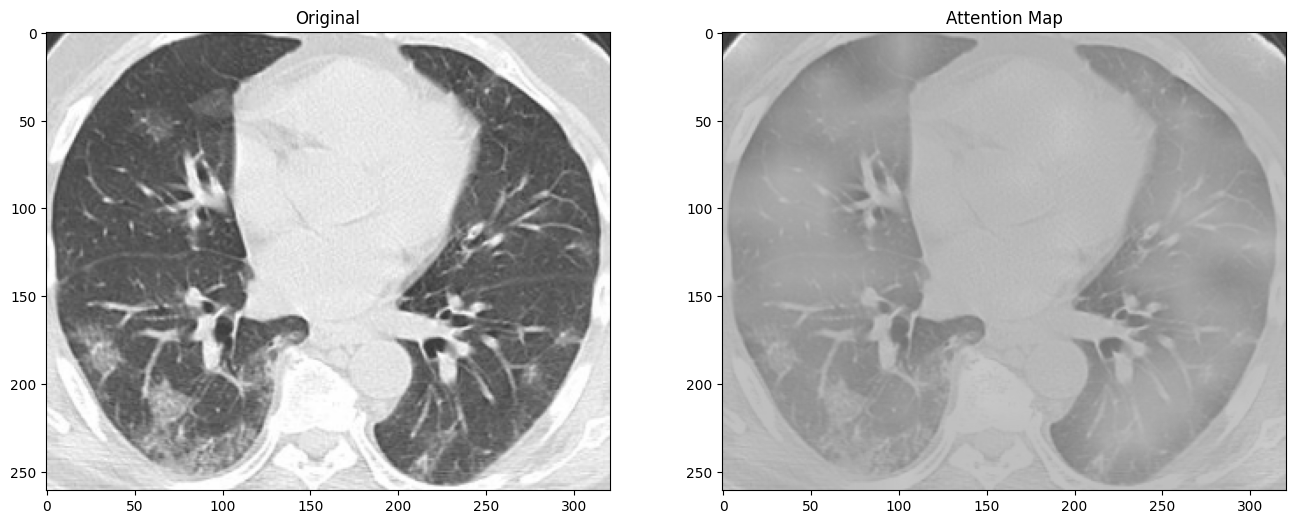

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)

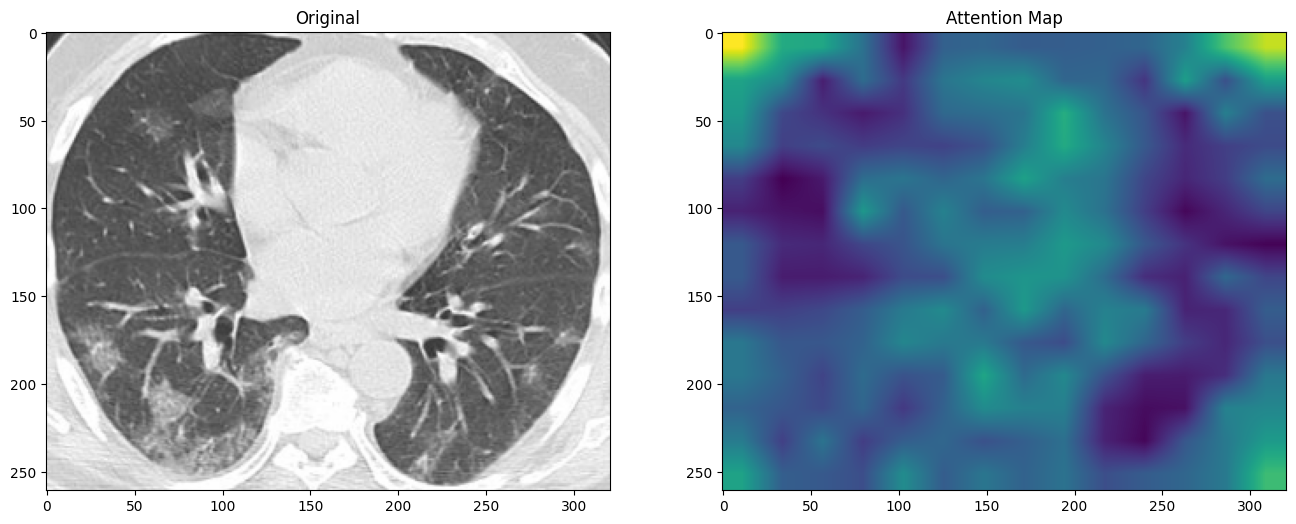

In [19]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(mask)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)